# Example of use of LSTM networks

This is adapted from a companion notebook for the guide course book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**For a better undertanding is recommended to read the notebook side by side with chapter 10 of the book.**



# Deep learning for timeseries: temperature forecasting

**Tasks:** predict the temperature 24 hours in the future, given a timeseries of hourly measurements of quantities such as atmospheric pressure and humidity, recorded over the recent past by a set of sensors on the roof of a building

Since the notebook was generated for TensorFlow 2.6 and Google Colab support TensorFlow 2.12, the first installed that version.

In [16]:
!pip3 install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 67.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 74.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 9.7 MB/s eta 0:00:00
  Atte

### Donwload and inspect the data of the Jena weather dataset

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.

The dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016.

Also, available at https://www.kaggle.com/datasets/mnassrib/jena-climate

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-04-30 14:37:09--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.9.13, 3.5.22.218, 52.216.41.16, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.9.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  23.8MB/s    in 0.5s    

2025-04-30 14:37:10 (23.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

# This outputs a count of 420,551 lines of data
# (each line is a timestep: a record of a date and 14 weather-related values)
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header) #Prints data headers
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


#### **Parsing the data**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1] # We store column 1 in the “temperature” array
    raw_data[i, :] = values[:] # We store all columns (including the temperature) in the “raw_data” array.

####**Plotting the temperature timeseries**

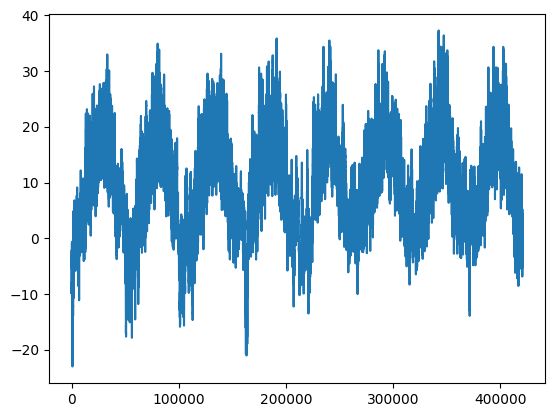

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature) # Temperature over the full temporal range (8 years) of the dataset (ºC)

####**Plotting the first 10 days of the temperature timeseries**

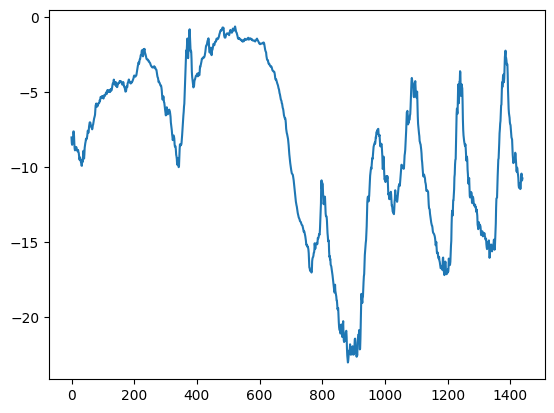

In [6]:
# Plot of the first 10 days of temperature data.
# Because the data is recorded every 10 minutes, you get 24 × 6 = 144 data points per day
plt.plot(range(1440), temperature[:1440])

## TODO: Plot now data for 15 days

#### **Computing the number of samples we'll use for each data split**

We’ll use the first 50% of the data for training, the following 25% for validation, and the last 25% for testing. When working with timeseries data, it’s important to use validation and test data that is more recent than the training data, because you’re trying to predict the future given the past, not the reverse, and your validation/test splits should reflect that.

**TODO:** Use a splitting ratio of 70-15-15 (training-validation-testing) to determine the number of samples per data split

In [7]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

#### **Normalizing the data**

The exact formulation of the problem will be as follows: given data covering the previous five days and sampled once per hour, can we predict the temperature in 24 hours?

First, let’s preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization.

But each timeseries in the data is on a different scale (for example, atmospheric pressure, measured in mbar, is around 1,000, while H2OC, measured in millimoles per mole, is around 3).

We’ll normalize each timeseries independently so that they all take small values on a similar scale. We’re going to use the first 210,225 timesteps as training data, so we’ll compute the mean and standard deviation only on this fraction of the data.

In [8]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

Next, let’s create a Dataset object that yields batches of data from the past five days along with a target temperature 24 hours in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate memory for every sample.

Instead, we’ll generate the samples on the fly while only keeping in memory the original raw_data and temperature arrays, and nothing more using timeseries_dataset_from_array().

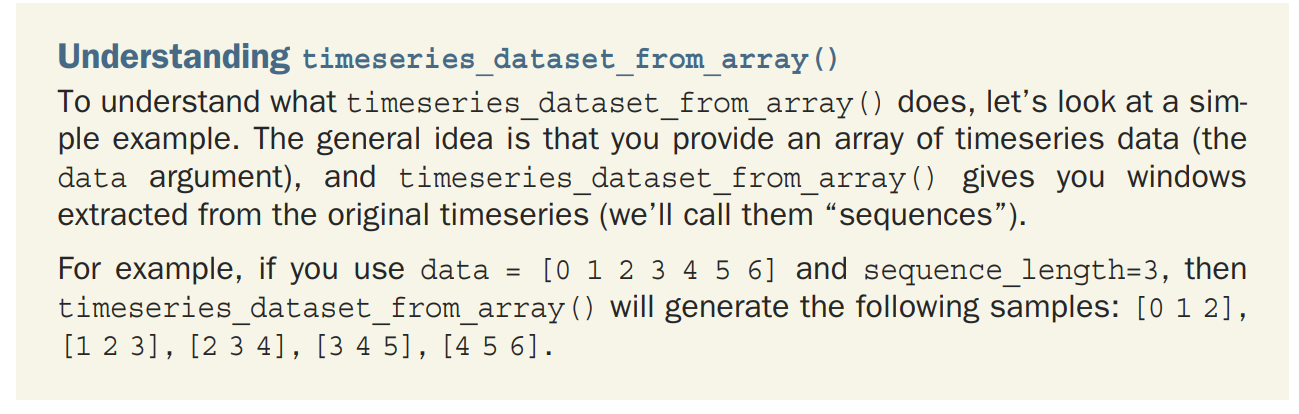

**TODO:**
* Explain the ouput of the next code. In particular, the parameters of **timeseries_dataset_from_array**
* After finish the exercise evaluated longer sequences

In [9]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10) # Generate an array of sorted integersfrom 0 to 9.
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


#### **Instantiating datasets for training, validation, and testing**
We’ll use timeseries_dataset_from_array() to instantiate three datasets: one for training, one for validation, and one for testing.

We’ll use the following parameter values:
􀂃 sampling_rate = 6—Observations will be sampled at one data point per hour:

* we will only keep one data point out of 6.

* sequence_length = 120—Observations will go back 5 days (120 hours).
* delay = sampling_rate * (sequence_length + 24 - 1)—The target for a sequence will be the temperature 24 hours after the end of the sequence.

When making the training dataset, we’ll pass start_index = 0 and end_index = num_train_samples to only use the first 50% of the data. For the validation dataset, we’ll pass start_index = num_train_samples and end_index = num_train_samples + num_val_samples to use the next 25% of the data.

Finally, for the test dataset, we’ll pass start_index = num_train_samples + num_val_samples to use the remaining samples.

In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

#### **Inspecting the output of one of our datasets**

Each dataset yields a tuple (samples, targets), where samples is a batch of 256 samples, each containing 120 consecutive hours of input data, and targets is the corresponding
array of 256 target temperatures.

Note that the samples are randomly shuffled, so two consecutive sequences in a batch (like samples[0] and samples[1]) aren’t necessarily temporally close.

In [11]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

#### **Computing the common-sense baseline MAE**

Before we start using black-box deep learning models to solve the temperatureprediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that we’ll have to beat in order to demonstrate the usefulness of more-advanced machine learning models. Such common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet).

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to always
predict that the temperature 24 hours from now will be equal to the temperature right now. Let’s

In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### A MLP-based solution

#### **Training and evaluating a densely connected model**

The following code shows a fully connected model (MLP) that starts by flattening the data and then runs it through two Dense layers. Note the lack of an activation function on the last Dense layer, which is typical for a regression problem.

We use mean
squared error (MSE) as the loss, rather than MAE, because unlike MAE, it’s smooth around zero, which is a useful property for gradient descent. We will monitor MAE by adding it as a metric in compile().

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

# We use a callback to save the bestperforming model.
callbacks = [ keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset, epochs=3,validation_data=val_dataset,callbacks=callbacks)

# Reload the best model and evaluate it on the test data.
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 [==============================] - 50s 61ms/step - loss: 17.1312 - mae: 3.1862 - val_loss: 12.2973 - val_mae: 2.7719
Epoch 2/3
819/819 [==============================] - 53s 64ms/step - loss: 10.7201 - mae: 2.5814 - val_loss: 11.7357 - val_mae: 2.7185
Epoch 3/3
405/405 [==============================] - 15s 36ms/step - loss: 11.8322 - mae: 2.7006
Test MAE: 2.70


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### **Plotting results**

**TODO:**
* What did you observed on the plot?
* Train the model using 1o epochs. It is observed any improvement?

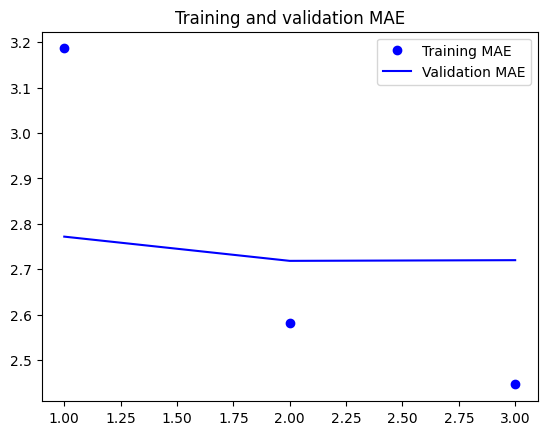

In [15]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

### A RNN-based solution

Recurrent neural network (RNN) architectures are designed specifically for this use in this case.

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.SimpleRNN(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_vanillaRNN.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_vanillaRNN.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 [==============================] - 78s 92ms/step - loss: 44.0769 - mae: 4.8986 - val_loss: 12.8670 - val_mae: 2.6802
Epoch 2/3
819/819 [==============================] - 75s 91ms/step - loss: 11.3322 - mae: 2.6101 - val_loss: 9.3958 - val_mae: 2.3837
Epoch 3/3
405/405 [==============================] - 19s 47ms/step - loss: 10.4613 - mae: 2.5158
Test MAE: 2.52


### **Plotting results**

**TODO:**
* What did you observed on the plot? There are any improvement compared with MLP model?
* Train the model using 1o epochs. It is observed any improvement?


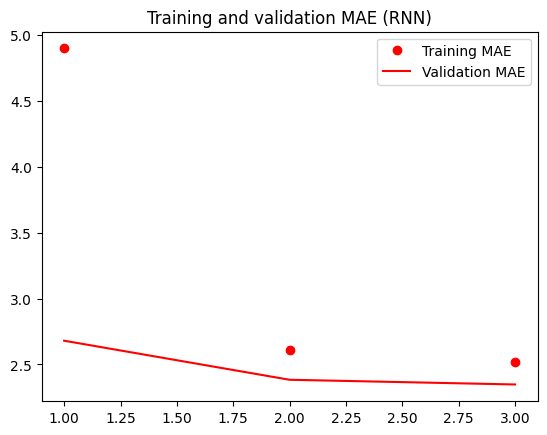

In [17]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "ro", label="Training MAE")
plt.plot(epochs, val_loss, "r", label="Validation MAE")
plt.title("Training and validation MAE (RNN)")
plt.legend()
plt.show()

### A LSTM-based solution

Now let's try using a LSTM model.

In [18]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_LSTM.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=3,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_LSTM.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/3
819/819 [==============================] - 117s 140ms/step - loss: 47.2879 - mae: 5.0628 - val_loss: 14.1868 - val_mae: 2.8242
Epoch 2/3
819/819 [==============================] - 114s 139ms/step - loss: 11.6175 - mae: 2.6338 - val_loss: 9.9336 - val_mae: 2.4435
Epoch 3/3
405/405 [==============================] - 24s 58ms/step - loss: 11.0940 - mae: 2.6205
Test MAE: 2.62


### **Plotting results**

**TODO:**
* What did you observed on the plot? There are any improvement compared with MLP and RNN models?
* Train the model using 1o epochs. It is observed any improvement?


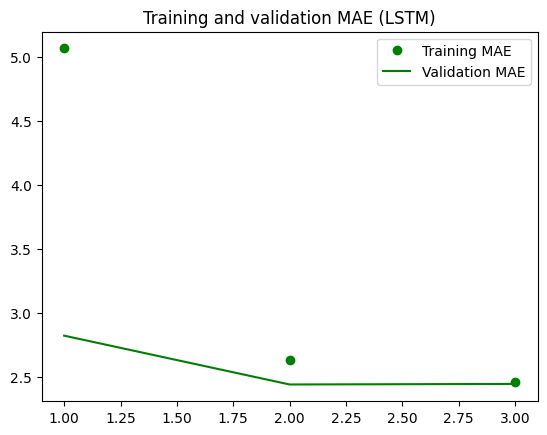

In [20]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "go", label="Training MAE")
plt.plot(epochs, val_loss, "g", label="Validation MAE")
plt.title("Training and validation MAE (LSTM)")
plt.legend()
plt.show()

### **Using the LSTM model to predict values**

In [21]:
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

405/405 [==============================] - 23s 54ms/step


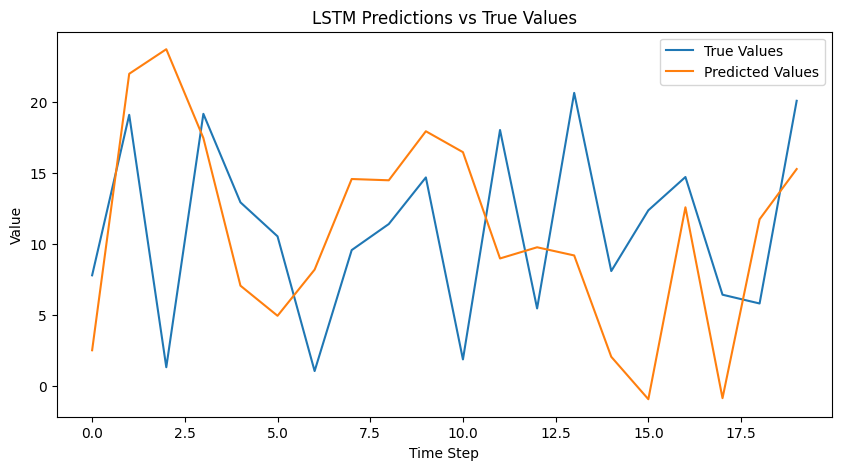

In [22]:
# Predict using the trained model
predictions = model.predict(test_dataset)

# Extract true values for plotting (optional: flatten to 1D if needed)
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(y_true[20:40], label='True Values')
plt.plot(predictions[20:40], label='Predicted Values')
plt.title('LSTM Predictions vs True Values')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()



## Advanced use of recurrent neural networks

**TODO**:
* Train new RNN and LSTM model by stacking several layers and using recurrent_dropout.
* Which effect has these strategies?